# Streamfunction For Vertically Integrated Transport

This notebook proceeds in several steps:

- read `TrspX,TrspY` transport vector field from file and compute its convergence.
- split `TrspX,TrspY` into rotational and divergent components (i.e., `Helmholtz Decomposition`).
- compute streamfunction from the non-divergent component.

_Note: this requires the `MeshArrays.jl v0.2.3` (upcoming release)_

In [1]:
using MeshArrays, Plots, FortranFiles
include(joinpath(dirname(pathof(MeshArrays)),"Plots.jl"))
include("prepare_transports.jl")

#1) get grid
if !isdir("../inputs/GRID_LLC90") 
    run(`git clone https://github.com/gaelforget/GRID_LLC90 ../inputs/GRID_LLC90`)
end
mygrid=GridSpec("LLC90","../inputs/"); GridVariables=GridLoad(mygrid);

#2) get transport
(TrspX, TrspY, TauX, TauY, SSH)=trsp_read(mygrid,"../inputs/GRID_LLC90/")

#3) compute convergence
TrspCon=convergence(TrspX,TrspY);

#4) apply mask & avoid isolated Canyons / singular matrices
msk=1.0 .+ 0.0 * mask(view(GridVariables["hFacC"],:,1),NaN,0.0)
TrspCon=msk*TrspCon;

### Helmholtz Decomposition

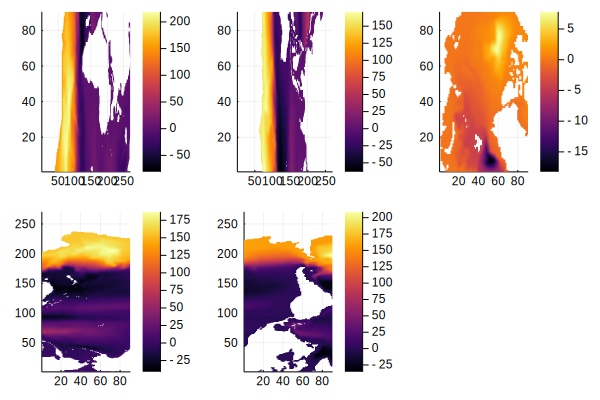

In [2]:
#scalar potential
TrspPot=ScalarPotential(TrspCon)

#plot result
heatmap(TrspPot,clims=(-5e5,5e5))

#Divergent vector field
(TrspXdiv,TrspYdiv)=gradient(TrspPot,GridVariables)
TrspXdiv=TrspXdiv.*GridVariables["DXC"]
TrspYdiv=TrspYdiv.*GridVariables["DYC"];

# Check that divergences match:
tmpCon=convergence(TrspXdiv,TrspYdiv)
heatmap(tmpCon-TrspCon) #TrspCon-tmpCon should be << TrspCon 

#Rotational vector field
TrspXrot = TrspX-TrspXdiv
TrspYrot = TrspY-TrspYdiv

#vector Potential
TrspPsi=VectorPotential(TrspX,TrspY,GridVariables)
heatmap(1e-6*msk*TrspPsi)